In [1]:
import random_VQE_data_prep as ran_VQE
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold 
import os
import pickle
import re

from sklearn.preprocessing import LabelEncoder
from qiskit import Aer
from qiskit.providers.fake_provider import FakeQuitoV2

In [2]:
def count_gate_paris(df, gates:str):
    l = df[gates]
    res = dict()
    for i in range(len(l)):
        tmp = str(l[i])
        if tmp in res.keys():
            res[tmp] += 1
        else:
            res[tmp] = 1
    return res

`extract_features(path)` as function to store all relevant features from the circuit at the given path into a df to perform linear regression

In [3]:
def extract_features(path):
    file = open(path, "rb")
    dict_ = pickle.load(file)
    #print(dict)
    #print(len(dict["Quantum_circuit"]))
    data = dict_["Quantum_circuit"][0].__dict__["_data"]
    #print(dict["Quantum_circuit"][0].draw())
    circuit = dict_["Quantum_circuit"][0]

    qubits = str(data)
    #print(qubits)

    # Split input_string before each "CircuitInstruction"
    instructions = qubits.split("CircuitInstruction")

    # Remove the empty string at the beginning (resulting from the initial split)
    instructions = instructions[1:]

    #patterns to get different values from datastring
    pattern_nq = r"num_qubits=(\d+)"
    pattern_nc = r"num_clbits=(\d+)"
    pattern_n = r"name='(\w+)'"
    pattern_p = r"params=\[(.*?)\]"
    pattern_gates = r"Qubit\(QuantumRegister\(5, 'q'\), (\d+)\)"
    #pattern_clb = r'clbits=\(\)\)' -> possibly clbits relevant?

    # Extracted numbers
    # find all values and store them in array to build df
    numbers = [int(match) for match in re.findall(pattern_nq, qubits)]
    clbits = [int(match_cl) for match_cl in re.findall(pattern_nq, qubits)]
    name = [match_name for match_name in re.findall(pattern_n, qubits)]
    params = [match_p for match_p in re.findall(pattern_p, qubits)]

    # loop over all Instructions to get per instruction a list of used qubits
    gates_all = []
    for instr in enumerate(instructions):
        gates = [match_gates for match_gates in re.findall(pattern_gates, str(instr))]
        gates_all.append(gates)


    #create new df to show parameters
    df_new =pd.DataFrame({'name': name, 'num_qubits': numbers, 'num_clbits': clbits, 'params': params, 'gates': gates_all})
    df_new = df_new.sort_values(by='num_qubits', ascending=False)
    df_new = df_new[df_new['num_qubits'] == 2].reset_index()

    res = dict()
    res['noisy_expectation'] = dict_['noisy_expectation']
    res['num_layers'] = dict_['num_layers']

    res['tot_num_gates'] = circuit.size()
    gates = circuit.count_ops()
    res['num_cx_gates'] = gates['cx']
    res['num_sx_gates'] = gates['sx']
    res['num_2_qubit_gates'] = len(df_new)

    # encoded obervable as binary number for locations where measured
    input_string = dict_['obervable']
    encoded_string = ''.join(['0' if char == 'I' else '1' for char in input_string])
    #res['observable'] = int(encoded_string)
    # if input_string[idx] == 'X':
    #     res['observable'] = 1 * (idx)
    # elif input_string[idx] == 'Y':
    #     res['observable'] = 2 * (idx)
    # elif input_string[idx] == 'Z':
    #     res['observable'] = 3 * idx
    # else:
    #     print('shit')

    # le = LabelEncoder()
    # obs = ran_VQE.create_all_single_q_observables()
    # encoded = le.fit_transform(obs)
    # for index, item in enumerate(obs):
    #     if item == input_string:
    #         res['observable'] = encoded[index]

    res['observable_dummy_1'] =not dict_['obervable'][0]=="I"
    res['observable_dummy_2'] =not dict_['obervable'][1]=="I"
    res['observable_dummy_3'] =not dict_['obervable'][2]=="I"
    res['observable_dummy_4'] =not dict_['obervable'][3]=="I"
    res['observable_dummy_5'] =not dict_['obervable'][4]=="I"
    
    # tmp = count_gate_paris(df_new, 'gates')
    # for i in tmp.keys():
    #     res['count_' + i] = tmp[i]
    res['target'] = dict_['ideal_expectation']

    return res 
extract_features("./pickles/circ_50.pickle")

{'noisy_expectation': 0.19644,
 'num_layers': 5,
 'tot_num_gates': 205,
 'num_cx_gates': 40,
 'num_sx_gates': 55,
 'num_2_qubit_gates': 40,
 'observable_dummy_1': False,
 'observable_dummy_2': False,
 'observable_dummy_3': True,
 'observable_dummy_4': False,
 'observable_dummy_5': False,
 'target': -0.06008128508333202}

In [4]:
def label_encode(categories):
    le = LabelEncoder()
    encoded = le.fit_transform(categories)
    return encoded

# Example usage
obs = ran_VQE.create_all_single_q_observables()
#categories = ['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX']
encoded = label_encode(obs)
print(f"Encoded: {encoded}")
obs

Encoded: [12  9  6  3  0 13 10  7  4  1 14 11  8  5  2]


['XIIII',
 'IXIII',
 'IIXII',
 'IIIXI',
 'IIIIX',
 'YIIII',
 'IYIII',
 'IIYII',
 'IIIYI',
 'IIIIY',
 'ZIIII',
 'IZIII',
 'IIZII',
 'IIIZI',
 'IIIIZ']

Split the generated data into an validation and train/test set. `train_frac` can be chosen and decides how many percent of the data are used to train and test the model.

In [5]:
def split_data(path="./pickles", train_frac = 0.8):
    ### split data into evaluation and training set
    assert train_frac < 1
    assert train_frac >= 0

    # shuffle data randomly to make different datasets
    all_files = os.listdir(path)
    # data_size = data.shape[0] # data.shape[0] changed to fit dictionary
    # indices = np.arange(data_size)  
    np.random.shuffle(all_files)
    #data_shuffled = data[indices]

    # split shuffeled data into test, train and eval according to fractions
    idx_eval = int(train_frac * len(all_files))

    files_train = all_files[:idx_eval]
    files_eval = all_files[idx_eval:]

    return files_train, files_eval

files_train, files_eval = split_data()

`file_to_data(files)` takes a list of circuits and generates the data using `extract_features(path)`

In [6]:
def file_to_data(files):
    a = list()
    for i, idx in enumerate(files):
        a.append(extract_features(f"./pickles/{idx}"))
    df = pd.DataFrame(a)
    return df

df_eval = file_to_data(files_eval)
df_train = file_to_data(files_train)

In [7]:
df_train

,noisy_expectation,num_layers,tot_num_gates,num_cx_gates,num_sx_gates,num_2_qubit_gates,observable_dummy_1,observable_dummy_2,observable_dummy_3,observable_dummy_4,observable_dummy_5,target
0,0.06018,2,94,16,25,16,False,False,False,True,False,0.070793
1,0.11754,4,171,32,46,32,False,False,False,True,False,0.075212
2,-0.56116,1,59,8,16,8,True,False,False,False,False,-0.697398
3,-0.18342,2,96,16,26,16,True,False,False,False,False,-0.273513
4,0.24886,3,131,24,35,24,False,False,True,False,False,0.147561
...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.02110,5,207,40,56,40,False,True,False,False,False,0.375754
796,0.12696,4,170,32,46,32,False,False,False,True,False,-0.101094
797,0.03062,4,170,32,46,32,False,False,False,True,False,0.276637
798,0.19058,3,133,24,36,24,False,False,True,False,False,0.032110


`split_data_kfold(df_train)` returns all the training and test data, as features (X) and the value to predict (y)

In [8]:
def split_data_kfold(df_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    X = df_train.drop(columns=['target'])
    y = df_train['target']
    
    for train_index, test_index in kf.split(df_train):
        X_train.append(X.iloc[train_index])
        X_test.append(X.iloc[test_index])
        y_train.append(y.iloc[train_index])
        y_test.append(y.iloc[test_index])
        
    return X_train, X_test, y_train, y_test

# Ensure the data is correct and check the type of first element
X_train, X_test, y_train, y_test = split_data_kfold(df_train)
#print(X_train[0], y_train[0])

`Linear_Reg(data)` returns the best model of the k = 5 splits according to the R2

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def Linear_Reg(X_train, X_test, y_train, y_test):
    # returns best fitting linear model of all trained models based on MSE
    # X_train, y_train, X_test, y_test are numpy arrays
    # returns best model, MSE, R2
    best_model = None
    best_model_MSE = float('inf')
    best_model_R2 = float('-inf')
    
    for i in range(len(X_train)):
        if X_train[i].empty or y_train[i].empty:
            print(f"Skipping fold {i} due to empty training data.")
            continue       
        
        model = LinearRegression()
        model.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])

        MSE = mean_squared_error(y_test[i], y_pred)
        R2 = r2_score(y_test[i], y_pred)

        print(f'Fold {i} - MSE: {MSE:.4f}, R2: {R2:.4f}')
        
        if R2 > best_model_R2:
            best_model = model
            best_model_MSE = MSE
            best_model_R2 = R2
    return best_model, best_model_MSE, best_model_R2

best_model, MSE, R2 = Linear_Reg(X_train, X_test, y_train, y_test)
print (f'MSE: {MSE}; R2: {R2}')

Fold 0 - MSE: 0.1024, R2: 0.4383
Fold 1 - MSE: 0.0602, R2: 0.5807
Fold 2 - MSE: 0.0686, R2: 0.5998
Fold 3 - MSE: 0.0659, R2: 0.6209
Fold 4 - MSE: 0.0815, R2: 0.4887
MSE: 0.06593620861391271; R2: 0.6208501891513929


In [10]:
X_eval = df_eval.drop(columns=['target']).reindex(columns=X_train[0].columns)
y_eval = df_eval['target']

y_pred_eval = best_model.predict(X_eval)

MSE = mean_squared_error(y_eval, y_pred_eval)
R2 = r2_score(y_eval, y_pred_eval)

print(f'Evaluation of best model - MSE: {MSE:.4f}, R2: {R2:.4f}')
print(best_model.coef_)
print(best_model.intercept_)


Evaluation of best model - MSE: 0.0589, R2: 0.6352
[ 1.16167559e+00 -8.45349864e-04 -5.37024072e-04 -6.76279891e-03
  1.15980769e-02 -6.76279891e-03  1.50576090e-02  7.38785769e-02
 -1.07824692e-01 -3.14570283e-02  5.03455346e-02]
-0.09955218213762117


In [11]:
print(y_eval[:10], y_pred_eval[:10])

0    0.265097
1    0.344987
2    0.332203
3    0.150092
4    0.276540
5   -0.182221
6    0.147419
7   -0.176117
8    0.068301
9    0.013144
Name: target, dtype: float64 [ 2.22816336e-01  2.79010694e-01  9.65894192e-02  7.95537798e-02
  1.81968693e-01  3.39242615e-02  2.69994442e-01 -9.91635777e-02
 -2.53075326e-04 -4.39201170e-04]


Text(0.5, 1.0, 'Correlation Matrix')

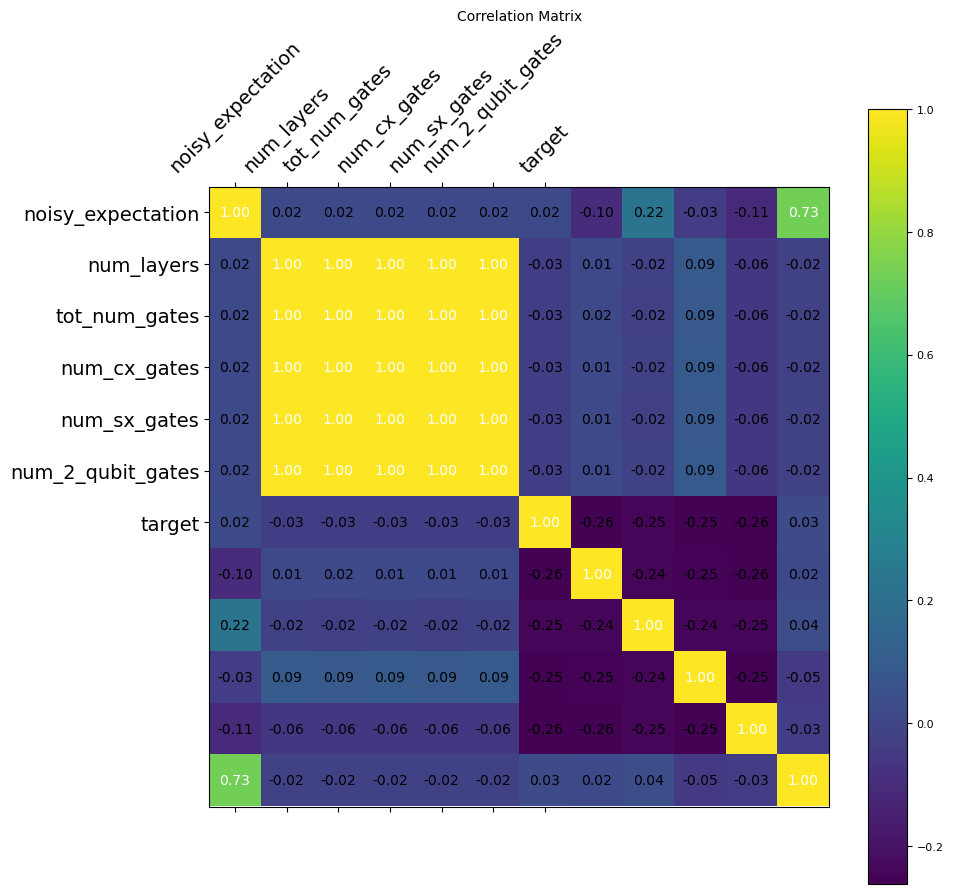

In [12]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(10, 10))
plt.matshow(df_train.corr(), fignum=f.number)
for (i, j), val in np.ndenumerate(df_train.corr().values):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')
plt.xticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df_train.select_dtypes(['number']).shape[1]), df_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=10)

Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor


def Random_Forest(X_train, X_test, y_train, y_test):
    # returns best fitting linear model of all trained models based on MSE
    # X_train, y_train, X_test, y_test are numpy arrays
    # returns best model, MSE, R2
    best_model = None
    best_model_MSE = float('inf')
    best_model_R2 = float('-inf')
    
    for i in range(len(X_train)): 
        rf = RandomForestRegressor()
        rf.fit(X_train[i], y_train[i])
        y_pred = rf.predict(X_test[i])

        MSE = mean_squared_error(y_test[i], y_pred)
        R2 = r2_score(y_test[i], y_pred)

        print(f'Fold {i} - MSE: {MSE:.4f}, R2: {R2:.4f}')
        
        if R2 > best_model_R2:
            best_model = rf
            best_model_MSE = MSE
            best_model_R2 = R2
    return best_model, best_model_MSE, best_model_R2

best_model, MSE, R2 = Random_Forest(X_train, X_test, y_train, y_test)
print (f'MSE: {MSE}; R2: {R2}')

y_pred_eval = best_model.predict(X_eval)

MSE = mean_squared_error(y_eval, y_pred_eval)
R2 = r2_score(y_eval, y_pred_eval)

print(f'Evaluation of best model - MSE: {MSE:.4f}, R2: {R2:.4f}')

Fold 0 - MSE: 0.1001, R2: 0.4507
Fold 1 - MSE: 0.0681, R2: 0.5253
Fold 2 - MSE: 0.0543, R2: 0.6837
Fold 3 - MSE: 0.0594, R2: 0.6587
Fold 4 - MSE: 0.0821, R2: 0.4848
MSE: 0.054266161196376284; R2: 0.6836535795631294
Evaluation of best model - MSE: 0.0738, R2: 0.5433


XGboost

In [14]:
# KFold cross-validation
def split_data_kfold_xg(df_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train_folds = []
    X_test_folds = []
    y_train_folds = []
    y_test_folds = []

    X = df_train.drop(columns=['target'])
    y = df_train['target']

    for train_index, test_index in kf.split(df_train):
        X_train_folds.append(X.iloc[train_index])
        X_test_folds.append(X.iloc[test_index])
        y_train_folds.append(y.iloc[train_index])
        y_test_folds.append(y.iloc[test_index])

    return X_train_folds, X_test_folds, y_train_folds, y_test_folds

X_train_folds, X_test_folds, y_train_folds, y_test_folds = split_data_kfold_xg(df_train)

In [15]:
from xgboost import XGBRegressor

for X_train_xg, X_test_xg, y_train_xg, y_test_xg in zip(X_train_folds, X_test_folds, y_train_folds, y_test_folds):
    model = XGBRegressor()
    model.fit(X_train_xg, y_train_xg)

    y_pred_train = model.predict(X_train_xg)
    y_pred_test = model.predict(X_test_xg)

    best_model_mse = float("inf")
    best_model_r2 = float("-inf")
    mse_test = mean_squared_error(y_test_xg, y_pred_test)
    r2_test = r2_score(y_test_xg, y_pred_test)

    if mse_test < best_model_mse:
        best_model = model
        best_model_mse = mse_test
        best_model_r2 = r2_test

# Evaluate the best model on the evaluation set
y_pred_eval = best_model.predict(X_eval)
mse_eval = mean_squared_error(y_eval, y_pred_eval)
r2_eval = r2_score(y_eval, y_pred_eval)

print(f'Best model - MSE: {best_model_mse:.4f}, R2: {best_model_r2:.4f}')
print(f'Evaluation of best model - MSE: {mse_eval:.4f}, R2: {r2_eval:.4f}')

Best model - MSE: 0.1157, R2: 0.2737
Evaluation of best model - MSE: 0.0955, R2: 0.4089


In [16]:
vqe = ran_VQE.data_loader("./pickles/circ_100.pickle")
circuit = vqe["Quantum_circuit"][0]
circuit.draw()

global phase: π/4
         ┌─────────┐┌────┐┌─────────┐ ░ ┌────────────┐┌────┐┌──────────────┐»
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(1.4144) ├┤ √X ├┤ Rz(-0.27104) ├»
         ├─────────┤├────┤├─────────┤ ░ ├────────────┤├────┤├──────────────┤»
q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(1.4144) ├┤ √X ├┤ Rz(-0.27104) ├»
         ├─────────┤├────┤├─────────┤ ░ ├────────────┤├────┤├──────────────┤»
q_2 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(1.4144) ├┤ √X ├┤ Rz(-0.27104) ├»
         ├─────────┤├────┤├─────────┤ ░ ├────────────┤├────┤├──────────────┤»
q_3 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(1.4144) ├┤ √X ├┤ Rz(-0.27104) ├»
         ├─────────┤├────┤├─────────┤ ░ ├────────────┤├────┤├──────────────┤»
q_4 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─┤ Rz(1.4144) ├┤ √X ├┤ Rz(-0.27104) ├»
         └─────────┘└────┘└─────────┘ ░ └────────────┘└────┘└──────────────┘»
 meas: 5/═══════════════════════════════════════════════════════════════════»
                                                                            »
«         ┌────┐┌─────────┐                                                  »
«q_0 -> 0 ┤ √X ├┤ Rz(π/2) ├──■───────────────────■───────────────────────────»
«         ├────┤├─────────┤┌─┴─┐┌─────────────┐┌─┴─┐                         »
«q_1 -> 1 ┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(-2.5975) ├┤ X ├──■───────────────────■──»
«         ├────┤├─────────┤└───┘└─────────────┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐»
«q_2 -> 2 ┤ √X ├┤ Rz(π/2) ├─────────────────────────┤ X ├┤ Rz(-2.5975) ├┤ X ├»
«         ├────┤├─────────┤                         └───┘└─────────────┘└───┘»
«q_3 -> 3 ┤ √X ├┤ Rz(π/2) ├──■───────────────────■───────────────────────────»
«         ├────┤├─────────┤┌─┴─┐┌─────────────┐┌─┴─┐                         »
«q_4 -> 4 ┤ √X ├┤ Rz(π/2) ├┤ X ├┤ Rz(-2.5975) ├┤ X ├─────────────────────────»
«         └────┘└─────────┘└───┘└─────────────┘└───┘                         »
« meas: 5/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«                                   ░ ┌─────────────┐┌────┐┌─────────────┐»
«q_0 -> 0 ──────────────────────────░─┤ Rz(0.94357) ├┤ √X ├┤ Rz(-2.0169) ├»
«                                   ░ ├─────────────┤├────┤├─────────────┤»
«q_1 -> 1 ──■───────────────────■───░─┤ Rz(0.94357) ├┤ √X ├┤ Rz(-2.0169) ├»
«           │                   │   ░ ├─────────────┤├────┤├─────────────┤»
«q_2 -> 2 ──┼───────────────────┼───░─┤ Rz(0.94357) ├┤ √X ├┤ Rz(-2.0169) ├»
«         ┌─┴─┐┌─────────────┐┌─┴─┐ ░ ├─────────────┤├────┤├─────────────┤»
«q_3 -> 3 ┤ X ├┤ Rz(-2.5975) ├┤ X ├─░─┤ Rz(0.94357) ├┤ √X ├┤ Rz(-2.0169) ├»
«         └───┘└─────────────┘└───┘ ░ ├─────────────┤├────┤├─────────────┤»
«q_4 -> 4 ──────────────────────────░─┤ Rz(0.94357) ├┤ √X ├┤ Rz(-2.0169) ├»
«                                   ░ └─────────────┘└────┘└─────────────┘»
« meas: 5/════════════════════════════════════════════════════════════════»
«                                                                         »
«         ┌────┐┌──────────┐                                                  »
«q_0 -> 0 ┤ √X ├┤ Rz(-π/2) ├──■───────────────────■───────────────────────────»
«         ├────┤├──────────┤┌─┴─┐┌─────────────┐┌─┴─┐                         »
«q_1 -> 1 ┤ √X ├┤ Rz(-π/2) ├┤ X ├┤ Rz(-3.0252) ├┤ X ├──■───────────────────■──»
«         ├────┤├──────────┤└───┘└─────────────┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐»
«q_2 -> 2 ┤ √X ├┤ Rz(-π/2) ├─────────────────────────┤ X ├┤ Rz(-3.0252) ├┤ X ├»
«         ├────┤├──────────┤                         └───┘└─────────────┘└───┘»
«q_3 -> 3 ┤ √X ├┤ Rz(-π/2) ├──■───────────────────■───────────────────────────»
«         ├────┤├──────────┤┌─┴─┐┌─────────────┐┌─┴─┐                         »
«q_4 -> 4 ┤ √X ├┤ Rz(-π/2) ├┤ X ├┤ Rz(-3.0252) ├┤ X ├─────────────────────────»
«         └────┘└──────────┘└───┘└─────────────┘└───┘                         »
« meas: 5/═══════════════════════════════════════════════════════════════

#### search for more features

In [17]:
#counts_qubit = circuit.num_qubits
counts_gates = circuit.count_ops()
size = circuit.size()
print([counts_gates, size])
circuit.num_unitary_factors()

[OrderedDict({'rz': 87, 'sx': 46, 'cx': 32, 'barrier': 6, 'measure': 5}), 170]


1

How to encode name of gates, gates operation performs on, ...?

predict ideal_expectation

In [18]:
from qiskit.providers.fake_provider import FakeQuitoV2
from qiskit.visualization import plot_gate_map, plot_error_map, plot_histogram
#plot_gate_map(vqe)

backend = FakeQuitoV2()
plot_error_map(backend)

from qiskit_experiments.library import LocalReadoutError
qubits = np.arange(vqe["Quantum_circuit"][0].num_qubits)
qubits

read_out = LocalReadoutError(qubits)
backend.qubit_properties(0)


QubitProperties(t1=4.8206656812414175e-05, t2=2.6816912572265807e-05, frequency=5300357189.009302)